# Research of advertisements for the sale of apartments

At your disposal is the data of the Yandex.Realty service - an archive of ads for the sale of apartments in St. Petersburg and neighboring settlements for several years. You need to learn how to determine the market value of real estate. Your job is to set the parameters. This will allow to build an automated system: it will track anomalies and fraudulent activity.

Two types of data are available for each apartment for sale. The first ones are entered by the user, the second ones are obtained automatically on the basis of cartographic data. For example, the distance to the center, airport, nearest park and reservoir.

### Open the data file and study the general information.

In [1]:
import pandas as pd 
from nltk.stem import SnowballStemmer 
russian_stemmer = SnowballStemmer('russian')
import numpy as np
import matplotlib.pyplot as plt



In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

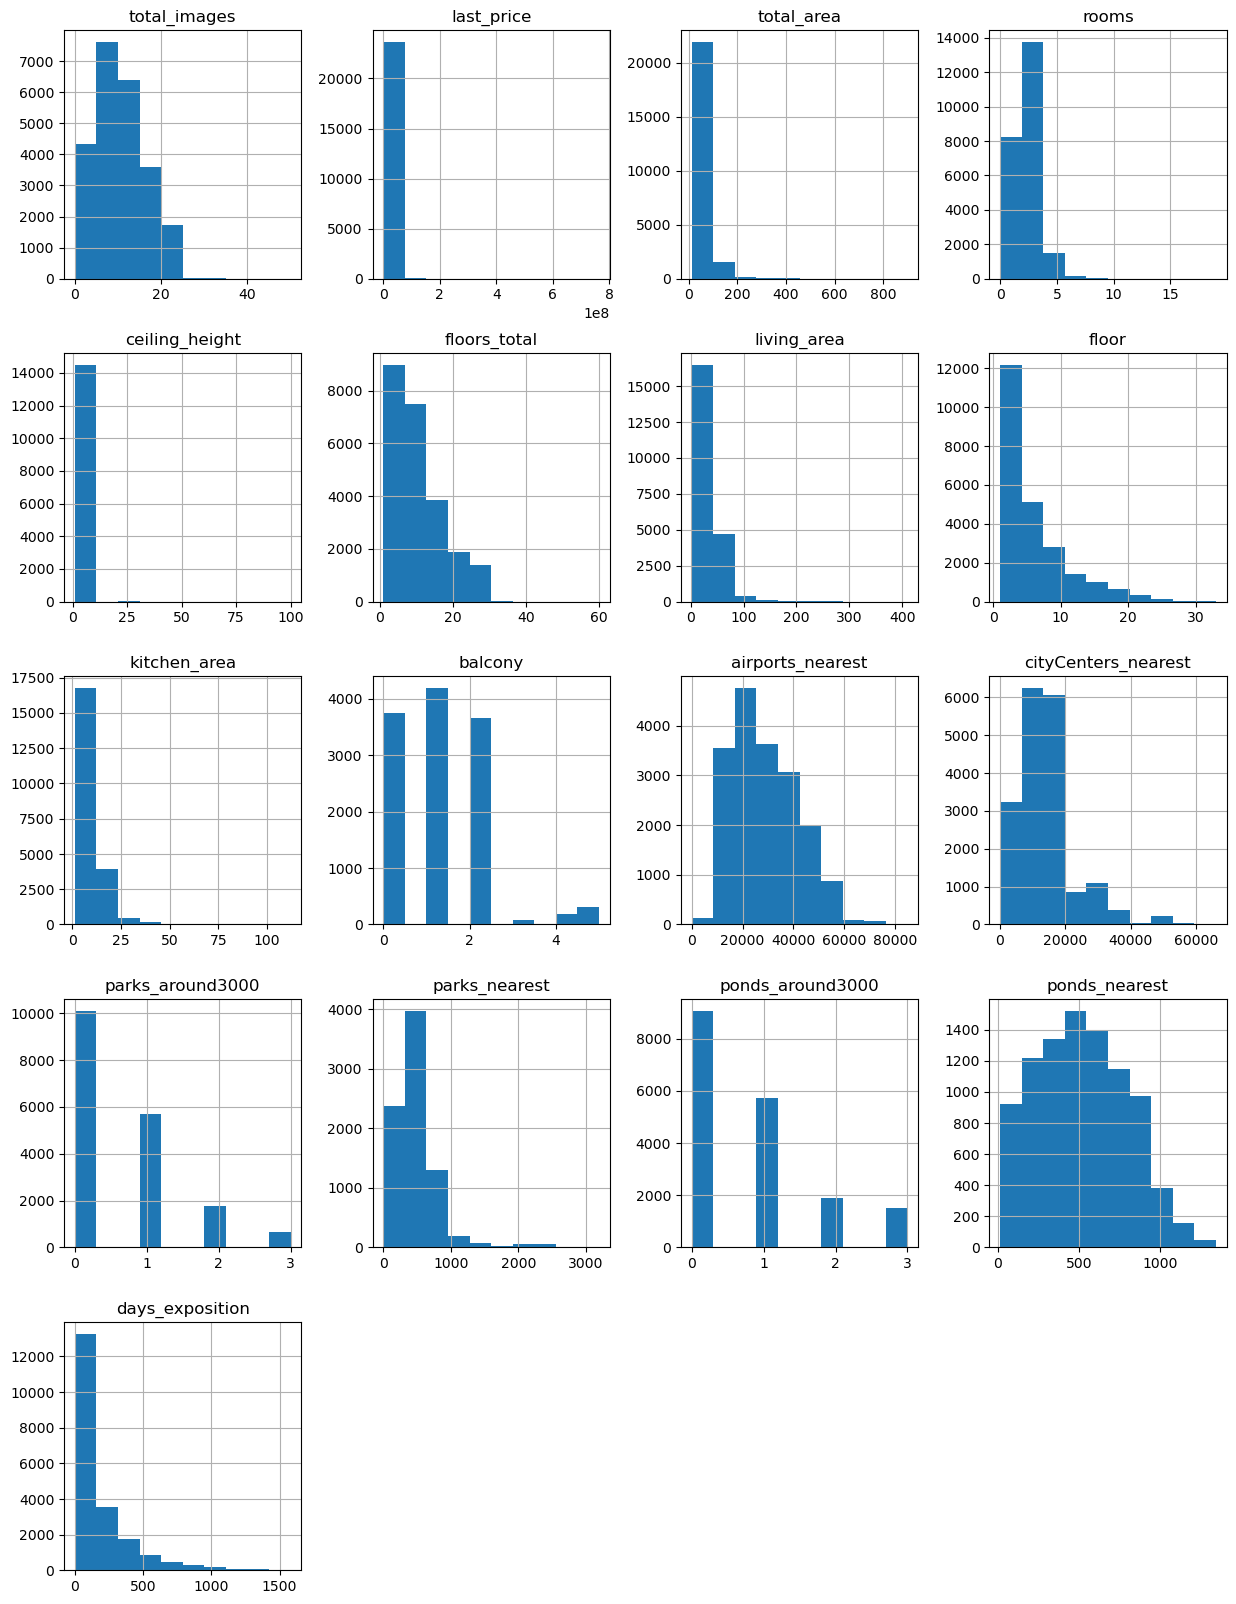

In [3]:
data.hist(figsize=(15, 20));

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [5]:
data = data.rename(columns = {'cityCenters_nearest' : 'city_centers_nearest'})

In [6]:
data.duplicated().sum()

0

### Data preprocessing

#### Looking for missing values in columns

At the stage of viewing information about the dataset, we see that there are 23699 rows of data, while there are gaps in many places, there are a lot of gaps in the columns with data on whether the apartment is an apartment, on the height of the ceiling, on the presence of balconies, on the nearest parks and reservoirs

In [7]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [8]:
data.isna().mean()*100

total_images             0.000000
last_price               0.000000
total_area               0.000000
first_day_exposition     0.000000
rooms                    0.000000
ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
floor                    0.000000
is_apartment            88.290645
studio                   0.000000
open_plan                0.000000
kitchen_area             9.612220
balcony                 48.605426
locality_name            0.206760
airports_nearest        23.384953
city_centers_nearest    23.287902
parks_around3000        23.283683
parks_nearest           65.909954
ponds_around3000        23.283683
ponds_nearest           61.559559
days_exposition         13.422507
dtype: float64

We see that 88% of the ads do not indicate whether the premises are apartments, 65% and 61% do not indicate the distance to parks and water bodies, respectively, 38% of the ads do not indicate the height of the ceiling, 23% of the ads do not indicate the distance to to the airport, to the city center, to parks within a radius of 3 km, to water bodies within a radius of 3 km

#### Consider the data types in each column

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [10]:
data['locality_name'] = data['locality_name'].astype('str')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

The data type needs to be changed to make it easier to work with the data. The 'locality_name' column is useful when we look for implicit duplicates in the names of settlements, and the 'first_day_exposition' column is useful when we get data about the days of the week

#### Let's examine the unique values in the column with names and eliminate implicit duplicates. Let's create a new one with names without duplicates.

In [11]:
data['locality_name'].unique() #look at the list of unique names of settlements

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [12]:
len(data['locality_name'].unique()) 

365

#### Using a stemmer to convert all names to dictionary form

In [13]:
data['locality_name_changed'] = data['locality_name'].copy()
for i in range(len(data)):
    data.loc[i, 'locality_name_changed'] = russian_stemmer.stem(data['locality_name'][i])


for i in range(len(data)):
    if 'поселок городского типа ' in data.loc[i, 'locality_name_changed']:
        data.loc[i, 'locality_name_changed'] = data.loc[i, 'locality_name_changed'].replace('поселок городского типа ', '')
    elif 'городской поселок ' in data.loc[i, 'locality_name_changed']:
        data.loc[i, 'locality_name_changed'] = data.loc[i, 'locality_name_changed'].replace('городской поселок ', '')
    elif 'деревня ' in data.loc[i, 'locality_name_changed']:
        data.loc[i, 'locality_name_changed'] = data.loc[i, 'locality_name_changed'].replace('деревня ', '')
    elif 'поселок ' in data.loc[i, 'locality_name_changed']:
        data.loc[i, 'locality_name_changed'] = data.loc[i, 'locality_name_changed'].replace('поселок ', '')

len(data['locality_name_changed'].unique())

311

In [14]:
data['locality_name_changed'].unique()

array(['санкт-петербург', 'шушар', 'янино-1', 'парголов', 'мурин',
       'ломонос', 'сертолов', 'петергоф', 'пушкин', 'кудров', 'коммунар',
       'колпин', 'красный бор', 'гатчин', 'федоровск', 'выборг',
       'кронштадт', 'кировск', 'новое девяткин', 'металлостр', 'лебяж',
       'сиверск', 'молодцов', 'кузьмоловск',
       'садовое товарищество новая ропш', 'павловск', 'пикколов',
       'всеволожск', 'волх', 'кингисепп', 'приозерск', 'сестрорецк',
       'куттуз', 'аннин', 'ефимовск', 'плодов', 'заклин', 'торкович',
       'первомайск', 'красное сел', 'понтон', 'сясьстр', 'стар',
       'лесколов', 'новый свет', 'сланц', 'село путилов', 'ивангород',
       'шлиссельбург', 'никольск', 'зеленогорск', 'сосновый бор', 'оржиц',
       'кальтин', 'романовк', 'бугр', 'рощин', 'кириш', 'луг', 'волосов',
       'отрадн', 'село павлов', 'оредеж', 'село копор', 'молодежн',
       'тихвин', 'побед', 'нурм', 'синявин', 'тосн', 'стрельн',
       'бокситогорск', 'александровск', 'лопухинк', 'пи

#### Find and eliminate rare and outliers.

In [15]:
data['balcony'] = data['balcony'].fillna(0) 

Gaps in the data could appear due to a technical factor (for example, when transferring data to a table), as well as due to a human factor (the owner of the apartment could miss some item, could forget or simply not know, for example, about the distance to the airport or the nearest body of water).

In [16]:
data['parks_around3000'] = data['parks_around3000'].fillna(value=0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(value=0)
data['is_apartment'] = data['is_apartment'].fillna(False)

We replace the gaps in the columns with the number of nearest parks and reservoirs with zero (since most likely if the number of parks and reservoirs nearby is not indicated, then they are not), and in the apartment column - with False, because apartments are not a common type of room , and if the type of room is apartments, then special emphasis is placed on this

In [17]:
data.dropna(subset=['locality_name'], inplace=True) 
data.dropna(subset=['floors_total'], inplace=True)
data = data.reset_index(drop=True)

The gaps in the columns with the names of settlements and with the number of storeys of the building are less than one percent in each (0.206% and 0.363%, respectively), so we can remove them

Let's calculate the coefficients of the ratio of the area of the kitchen and living area to the entire area, and then fill in the gaps with their help

In [18]:
living_to_total = (data['living_area'] / data['total_area']).mean()
living_to_total

0.5649479605594985

In [19]:
kitchen_to_total = (data['kitchen_area'] / data['total_area']).mean()
kitchen_to_total

0.18732402442071253

In [20]:
data['living_area'].fillna(living_to_total * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_to_total * data['total_area'], inplace=True)

Fill in the height of the ceiling

In [21]:
ceiling_delete = 0 # create counter of remote ceilings
for i in range(len(data)):
    if data['ceiling_height'][i] >= 20:
        data.loc[i, 'ceiling_height'] = data.loc[i, 'ceiling_height'] // 10
    elif data['ceiling_height'][i] >= 6:
        data.loc[i, 'ceiling_height'] = data['ceiling_height'].median()
        ceiling_delete += 1
    elif data['ceiling_height'][i] < 2:
        data.loc[i, 'ceiling_height'] = data['ceiling_height'].median()
        ceiling_delete += 1
#if the specified ceiling height is greater than 20, then this is most likely an error
#if the height of the ceilings is more than 6 meters or two, then we will
#replace this value with 0, then we will replace them with median values
ceiling_delete = ceiling_delete / len(data['ceiling_height']) #got 11 values
ceiling_delete # counting how many values were deleted in percentage = 0.00046%

0.0004234955321221361

In [22]:
data.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23613.000000,2.361300e+04,23613.000000,23613,23613.000000,14495.000000,23613.000000,23613.000000,23613.000000,23613.000000,23613.000000,18081.000000,18104.000000,23613.000000,8045.000000,23613.000000,9061.000000,20441.000000
mean,9.874518,6.540555e+06,60.340678,2017-11-09 06:29:41.018930176,2.071147,2.726021,10.673824,34.571407,5.877313,10.568630,0.593063,28788.008185,14185.084015,0.468810,490.554630,0.590480,518.209469,180.884839
min,0.000000,1.219000e+04,12.000000,2014-11-27 00:00:00,0.000000,2.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,2017-05-15 00:00:00,1.000000,2.510000,5.000000,19.000000,2.000000,7.000000,0.000000,18575.000000,9233.750000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2017-12-12 00:00:00,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13093.000000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.799000e+06,69.800000,2018-08-25 00:00:00,3.000000,2.800000,16.000000,42.100000,8.000000,12.000000,1.000000,37242.000000,16287.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,7.630000e+08,900.000000,2019-05-03 00:00:00,19.000000,10.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000
std,5.681541,1.090172e+07,35.648988,NaN,1.078380,0.284954,6.597173,22.340445,4.873539,6.095654,0.960307,12626.209956,8614.132292,0.748489,341.336698,0.884436,277.887489,219.685543


In [23]:
def quartile_range(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    dfq = df.loc[(df[column] < q3 + 1.5*iqr) & (df[column] > q1 - 1.5*iqr), column]
    return dfq
# Columns with outliers
list_features = ['last_price', 'total_area', 'kitchen_area', 'living_area', 'ceiling_height']
for row in list_features:
    data[row] = quartile_range(data, row)

In [24]:
data.describe()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23613.000000,2.156400e+04,22374.000000,23613,23613.000000,13686.000000,23613.000000,22730.000000,23613.000000,22266.000000,23613.000000,18081.000000,18104.000000,23613.000000,8045.000000,23613.000000,9061.000000,20441.000000
mean,9.874518,4.839129e+06,54.346138,2017-11-09 06:29:41.018930176,2.071147,2.680255,10.673824,31.514998,5.877313,9.463441,0.593063,28788.008185,14185.084015,0.468810,490.554630,0.590480,518.209469,180.884839
min,0.000000,1.219000e+04,12.000000,2014-11-27 00:00:00,0.000000,2.200000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.300000e+06,39.400000,2017-05-15 00:00:00,1.000000,2.500000,5.000000,18.700000,2.000000,7.000000,0.000000,18575.000000,9233.750000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.400000e+06,50.100000,2017-12-12 00:00:00,2.000000,2.640000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13093.000000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.000000e+06,65.600000,2018-08-25 00:00:00,3.000000,2.760000,16.000000,40.600000,8.000000,11.100000,1.000000,37242.000000,16287.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,1.189440e+07,114.400000,2019-05-03 00:00:00,19.000000,3.230000,60.000000,76.700000,33.000000,19.481699,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000
std,5.681541,2.217292e+06,19.349696,NaN,1.078380,0.184451,6.597173,13.752287,4.873539,3.176745,0.960307,12626.209956,8614.132292,0.748489,341.336698,0.884436,277.887489,219.685543


### Count and add new columns to the table

In [25]:
data['price_for_sqr_m'] = data['last_price'] // data['total_area']

In [26]:
data['day_of_week_exposition'] = data['first_day_exposition'].dt.weekday

In [27]:
data['month_exposition'] = data['first_day_exposition'].dt.month

In [28]:
data['year_exposition'] = data['first_day_exposition'].dt.year

In [29]:
def floors(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floors, axis=1)

In [30]:
data['city_centers_distance'] = round(data['city_centers_nearest'] / 1000)
data['city_centers_nearest']

0        16028.0
1        18603.0
2        13933.0
3         6800.0
4         8098.0
          ...   
23608     4232.0
23609        NaN
23610        NaN
23611    10364.0
23612        NaN
Name: city_centers_nearest, Length: 23613, dtype: float64

In [31]:
data['city_centers_distance']

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23608     4.0
23609     NaN
23610     NaN
23611    10.0
23612     NaN
Name: city_centers_distance, Length: 23613, dtype: float64

### Conduct exploratory data analysis

#### Let's study the parameters of apartments and build histograms

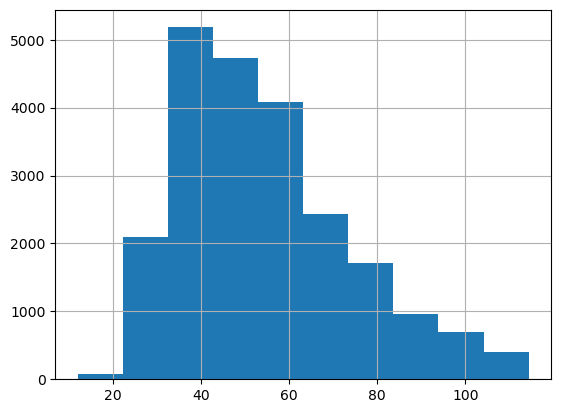

In [32]:
data['total_area'].hist();

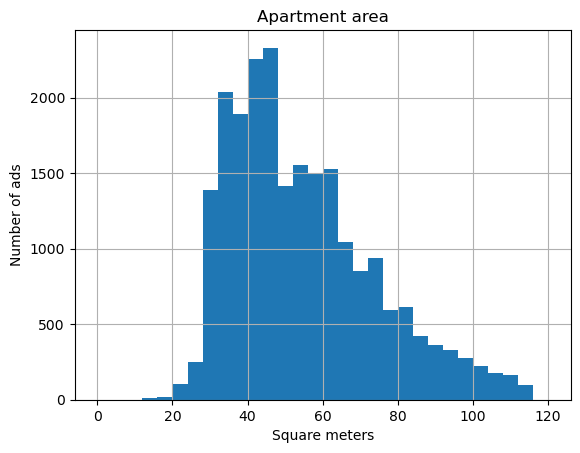

In [33]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['total_area'], bins = 30, range=(0, 120))
ax.set_title('Apartment area')
ax.set_xlabel('Square meters')
ax.set_ylabel('Number of ads')
plt.show()

We got the Poisson distribution, we see that the most popular apartments are with an area of 30 to 70 sq.m.

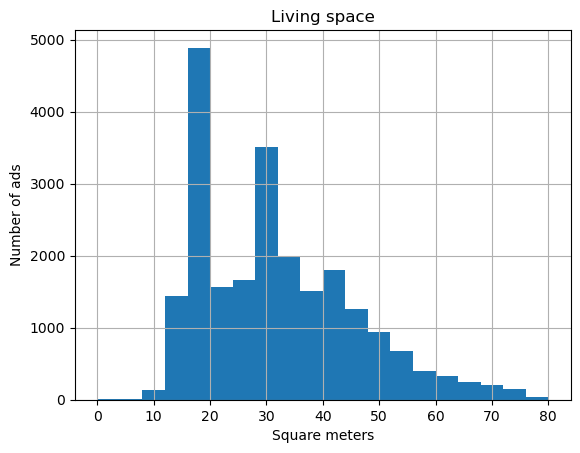

In [34]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['living_area'], bins = 20, range=(0, 80))
ax.set_title('Living space')
ax.set_xlabel('Square meters')
ax.set_ylabel('Number of ads')
plt.show()

Most often, apartments are sold from 15 to 50 sq.m.

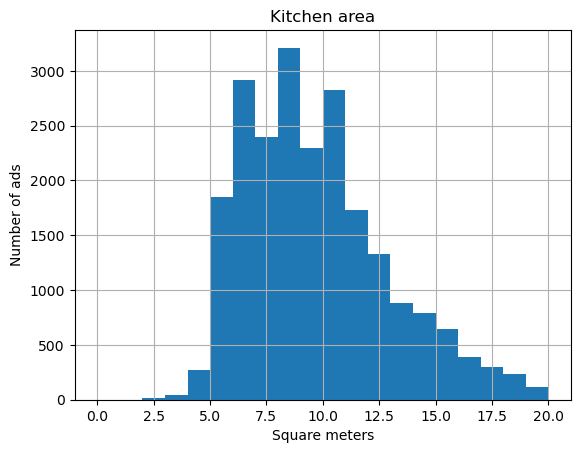

In [35]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['kitchen_area'], bins = 20, range=(0, 20))
ax.set_title('Kitchen area')
ax.set_xlabel('Square meters')
ax.set_ylabel('Number of ads')
plt.show()

Most often, the ads indicate the area of the kitchen from 5 to 15 sq.m.

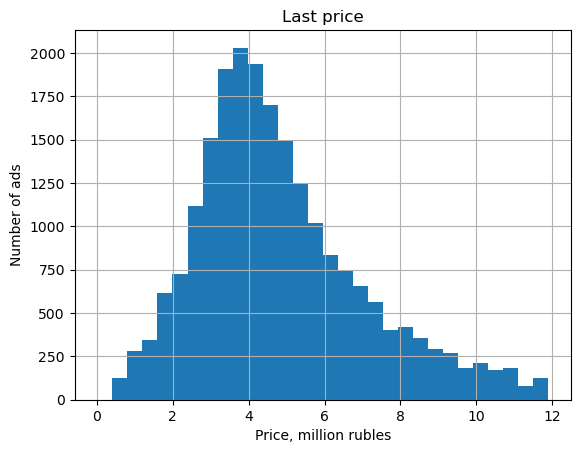

In [36]:
fig, ax = plt.subplots()
ax.grid()
ax.hist((data['last_price'] / 1000000), bins = 30)
ax.set_title('Last price')
ax.set_xlabel('Price, million rubles')
ax.set_ylabel('Number of ads')
plt.show()

Most often, the ads indicate the price from 2 million to 7 million rubles.

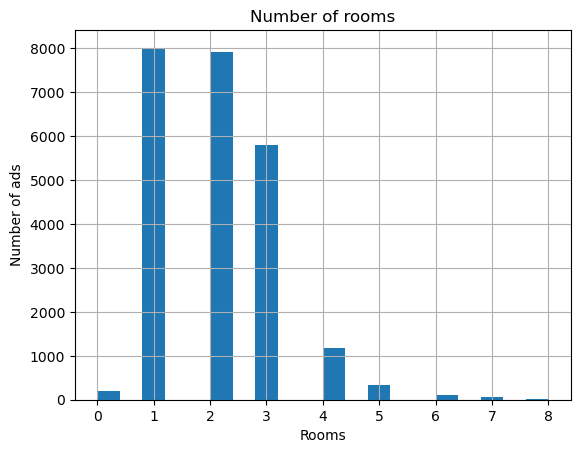

In [37]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['rooms'], bins = 20, range=(0,8))
ax.set_title('Number of rooms')
ax.set_xlabel('Rooms')
ax.set_ylabel('Number of ads')
plt.show()

Most of all one-room and two-room apartments are sold, a little less than three-room apartments

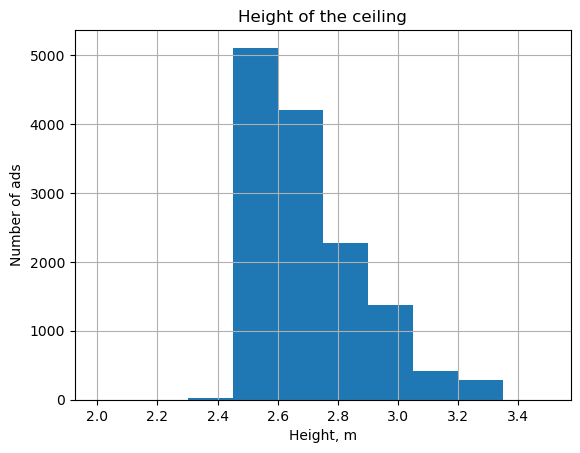

In [38]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['ceiling_height'], bins = 10, range=(2, 3.5))
ax.set_title('Height of the ceiling')
ax.set_xlabel('Height, m')
ax.set_ylabel('Number of ads')
plt.show()

Most often, the ads indicate the height of the ceiling from 2.5 m to 3 m

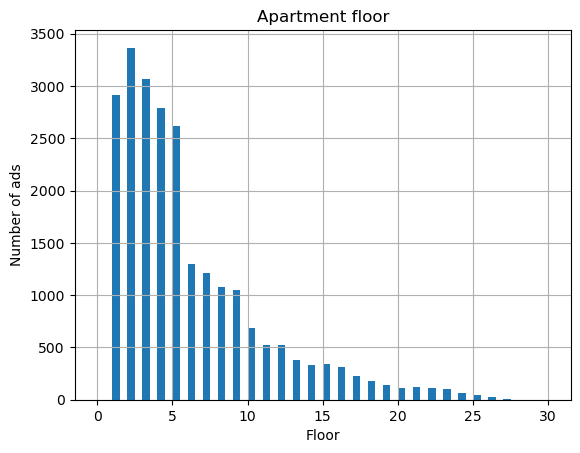

In [39]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['floor'], bins = 60, range=(0, 30))
ax.set_title('Apartment floor')
ax.set_xlabel('Floor')
ax.set_ylabel('Number of ads')
plt.show()

Most often, apartments are sold on the second, third, first, fourth and fifth floors, respectively.

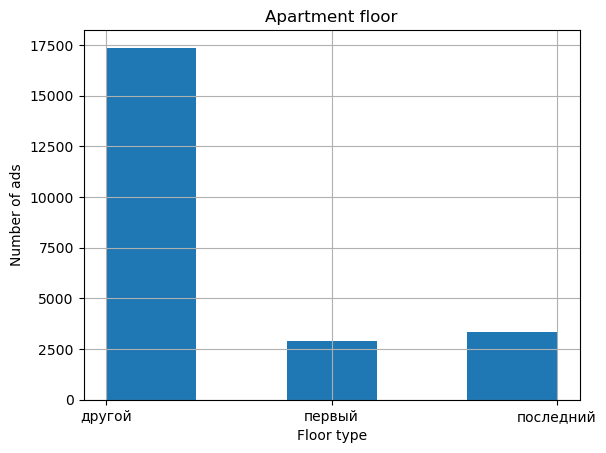

In [40]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['floor_type'], bins = 5)
ax.set_title('Apartment floor')
ax.set_xlabel('Floor type')
ax.set_ylabel('Number of ads')
plt.show()

Most sales are from apartments not on the first and not on the top floor

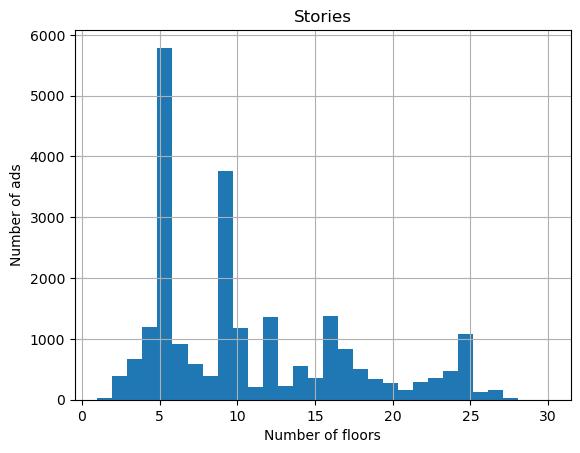

In [41]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['floors_total'], bins = 30, range=(1, 30))
ax.set_title('Stories')
ax.set_xlabel('Number of floors')
ax.set_ylabel('Number of ads')
plt.show()

Most apartments are sold in five-story and nine-story buildings

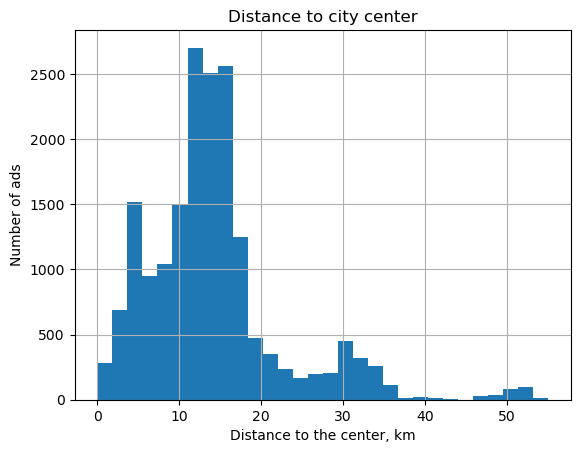

In [42]:
fig, ax = plt.subplots()
ax.grid()
ax.hist((data['city_centers_nearest'] / 1000), bins = 30, range=(0, 55))
ax.set_title('Distance to city center')
ax.set_xlabel('Distance to the center, km')
ax.set_ylabel('Number of ads')
plt.show()

Most often apartments are located 10 to 18 km from the city center

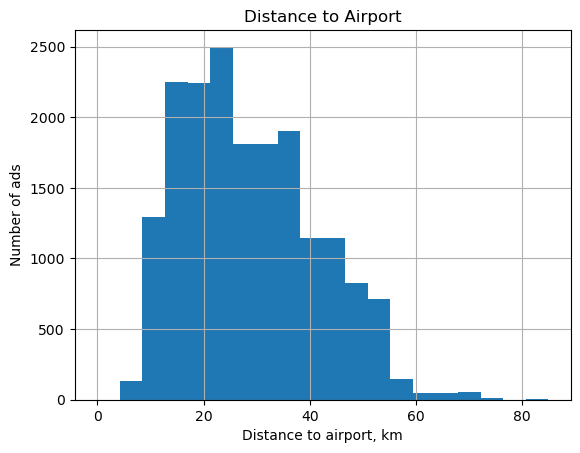

In [43]:
fig, ax = plt.subplots()
ax.grid()
ax.hist((data['airports_nearest'] / 1000), bins = 20)
ax.set_title('Distance to Airport')
ax.set_xlabel('Distance to airport, km')
ax.set_ylabel('Number of ads')
plt.show()

Most apartments are located between 10 and 45 km from the airport.

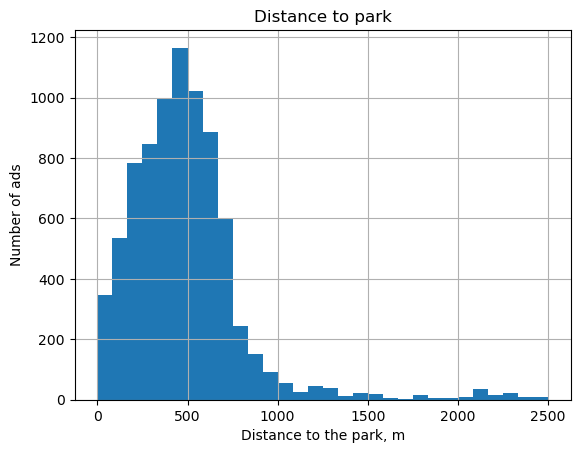

In [44]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['parks_nearest'], bins = 30, range=(0, 2500))
ax.set_title('Distance to park')
ax.set_xlabel('Distance to the park, m')
ax.set_ylabel('Number of ads')
plt.show()

Most of the apartments in the listings have the nearest park within one kilometer

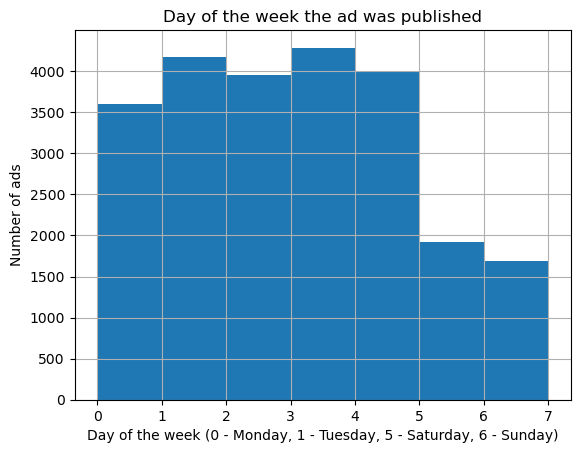

In [45]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['day_of_week_exposition'], bins = 7, range=(0,7))
ax.set_title('Day of the week the ad was published')
ax.set_xlabel('Day of the week (0 - Monday, 1 - Tuesday, 5 - Saturday, 6 - Sunday)')
ax.set_ylabel('Number of ads')
plt.show()

There are more ads on weekdays than on weekends.

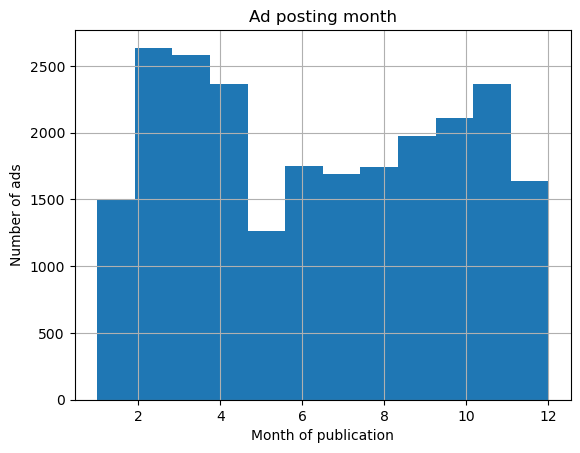

In [46]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['month_exposition'], bins = 12)
ax.set_title('Ad posting month')
ax.set_xlabel('Month of publication')
ax.set_ylabel('Number of ads')
plt.show()

The fewest ads are posted in May, January and December

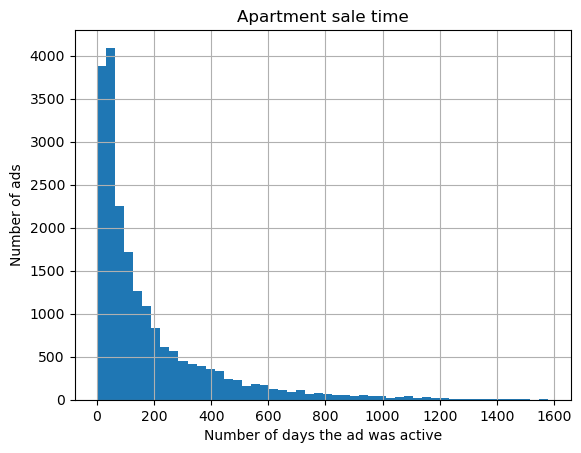

In [47]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['days_exposition'], bins = 50)
ax.set_title('Apartment sale time')
ax.set_xlabel('Number of days the ad was active')
ax.set_ylabel('Number of ads')
plt.show()

Conclusion: the larger the area, the higher the cost. The correlation of these parameters is extremely high. The number of rooms affects the price (more rooms - more price), but the dependence is lower than that of the area. Two conclusions can be drawn: there are apartments with large rooms; apartments in the center consist of a small number of rooms, but are quite high.

The most expensive apartment options are located in the city center, but there are also quite cheap options in the center.

The first floor directly affects the cost of an apartment - on average, apartments on the 1st floor are much cheaper. Slightly more expensive than the top floor. The highest cost is for apartments located not on the 1st and not on the top floor.

#### We will study how quickly apartments were sold

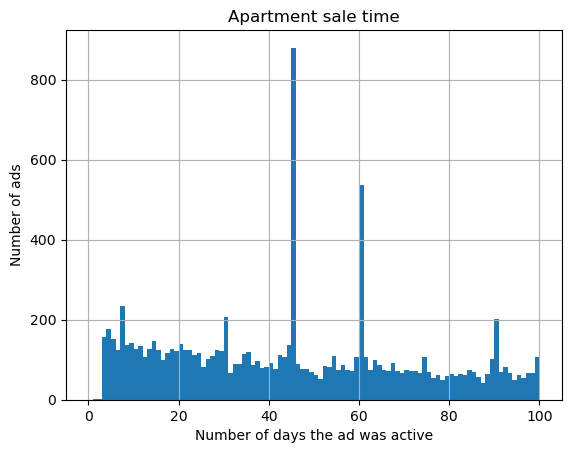

In [48]:
fig, ax = plt.subplots()
ax.grid()
ax.hist(data['days_exposition'], bins = 100, range=(0,100))
ax.set_title('Apartment sale time')
ax.set_xlabel('Number of days the ad was active')
ax.set_ylabel('Number of ads')
plt.show()

We see peaks (outliers) where 7, 30, 45, 60 and 90 days. Perhaps after so many days, ads automatically become inactive.

In [49]:
data['days_exposition'].describe()

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [50]:
data['days_exposition'].mean()

180.88483929357665

The average period for which an apartment is sold is 180 days (six months), and the median is 95 (slightly more than three months). This means that half of all apartments are sold in three months or less, and the other half in more than three months. At the same time, according to some ads, the sale period can be up to four years.

If the ad was placed for 45 days or less, then it can be considered a fast sale, if 231 days or more - a very long one

#### We will study what factors most affect the total (full) cost of the object

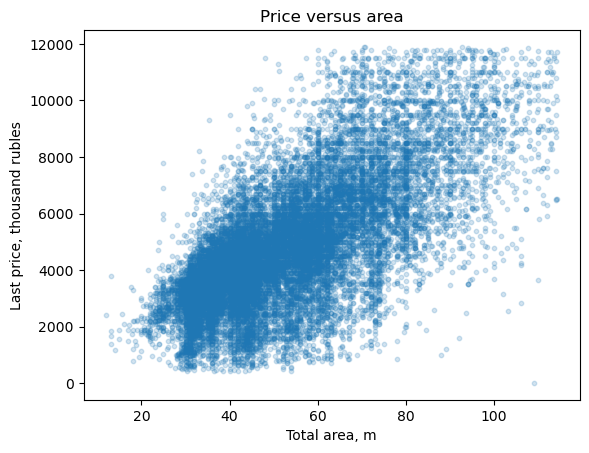

In [51]:
data['last_price'] = data['last_price'] / 1000
data.plot.scatter(x='total_area', y='last_price', s = 10, alpha = 0.2, 
                  xlabel='Total area, m', ylabel='Last price, thousand rubles',
                  title='Price versus area');
data['last_price'] = data['last_price'] * 1000

In [52]:
data.pivot_table(index='floor', values=['total_area', 'last_price']).corr()

,last_price,total_area
last_price,1.000000,0.905269
total_area,0.905269,1.000000


The correlation between price and area is very high, and the graph shows that the larger the area, the higher the price.

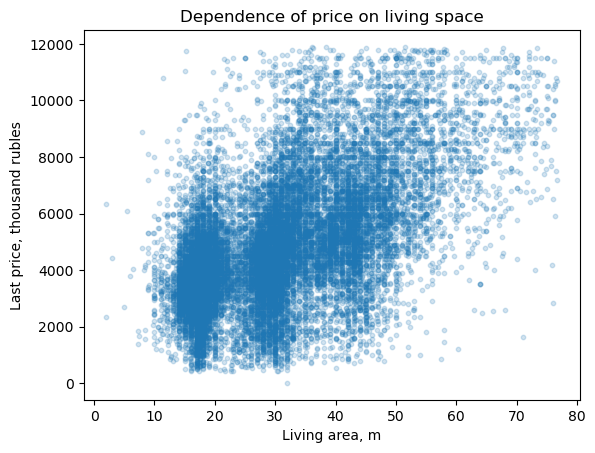

In [53]:
data['last_price'] = data['last_price'] / 1000
data.plot.scatter(x='living_area', y='last_price', s = 10, alpha = 0.2, 
                  xlabel='Living area, m', ylabel='Last price, thousand rubles',
                  title='Dependence of price on living space');
data['last_price'] = data['last_price'] * 1000

In [54]:
data.pivot_table(index='floor', values=['living_area', 'last_price']).corr()

,last_price,living_area
last_price,1.000000,0.730176
living_area,0.730176,1.000000


The correlation of price and living space is high, the dependence of price on living space is visible, although not as obvious as on the total area

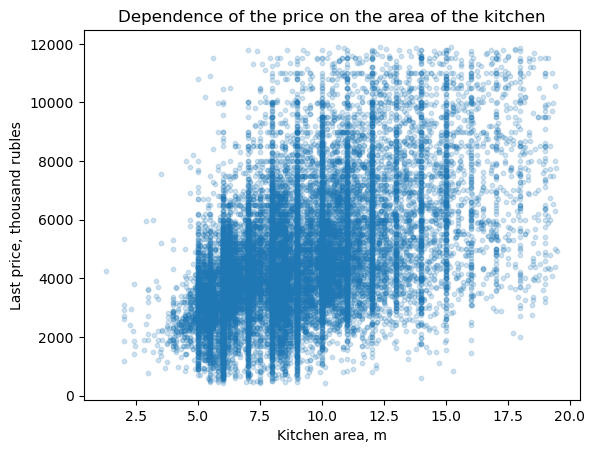

In [55]:
data['last_price'] = data['last_price'] / 1000
data.plot.scatter(x='kitchen_area', y='last_price', s = 10, alpha = 0.2, 
                  xlabel='Kitchen area, m', ylabel='Last price, thousand rubles',
                  title='Dependence of the price on the area of the kitchen');
data['last_price'] = data['last_price'] * 1000

In [56]:
data.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr()

,kitchen_area,last_price
kitchen_area,1.00000,0.44128
last_price,0.44128,1.00000


In apartments on the same floor, the correlation between price and kitchen area is low, the dependence of the price on the kitchen area is visible, but not always, for each value of the kitchen area there are many different price values.

In [57]:
data['last_price'] = data['last_price'] / 1000000

Convert price values from rubles to millions of rubles

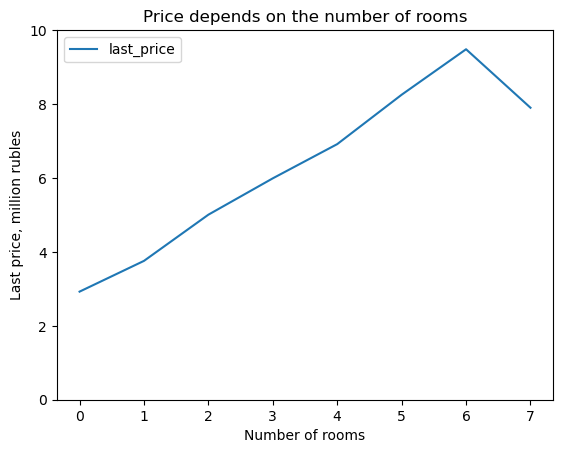

In [58]:
price_floor = data.pivot_table(index='rooms', values='last_price')
price_floor.plot(ylim=(0, 10), xlabel='Number of rooms',
                 ylabel='Last price, million rubles',
                 title='Price depends on the number of rooms');

The dependence of the price on the number of apartments is directly proportional, the more rooms, the higher the price up to six rooms, with seven rooms the average price is slightly lower

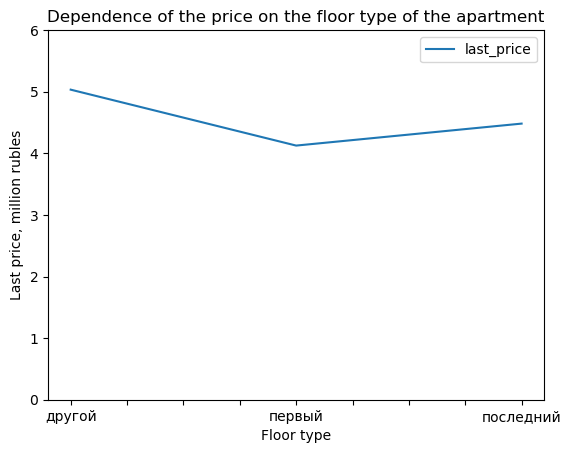

In [59]:
price_floor = data.pivot_table(index='floor_type', values='last_price')
price_floor.plot(ylim=(0, 6), xlabel='Floor type',
                 ylabel='Last price, million rubles',
                 title='Dependence of the price on the floor type of the apartment');

The price of apartments on the first floor is less than other apartments

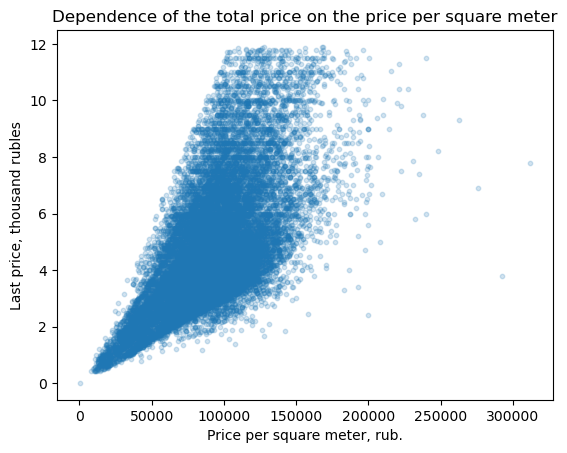

In [60]:
data.plot.scatter(x='price_for_sqr_m', y='last_price', s = 10, alpha = 0.2, 
                  xlabel='Price per square meter, rub.',
                  ylabel='Last price, thousand rubles',
                  title='Dependence of the total price on the price per square meter');

The dependence of the price of an apartment on the price per square meter is large

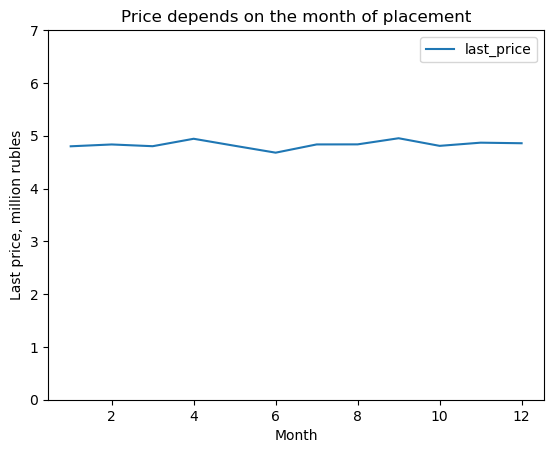

In [61]:
price_floor = data.pivot_table(index='month_exposition', values='last_price')
price_floor.plot(ylim=(0, 7), xlabel='Month',
                 ylabel='Last price, million rubles',
                 title='Price depends on the month of placement');

In [62]:
data.pivot_table(index='month_exposition', values=['price_for_sqr_m',
                                                   'last_price',
                                                   'total_area'])

,last_price,price_for_sqr_m,total_area
month_exposition,,,
1,4.799730,91785.508915,54.238982
2,4.834506,91551.050230,54.338708
3,4.801455,92166.226439,54.134994
4,4.942300,93750.707363,54.627731
5,4.809500,91878.605585,53.879672
6,4.679061,89611.326851,53.811906
7,4.835079,92124.593544,54.266248
8,4.836221,92970.907021,53.897759
9,4.952202,93209.930469,54.854445


The dependence of the price on the month of placement is small

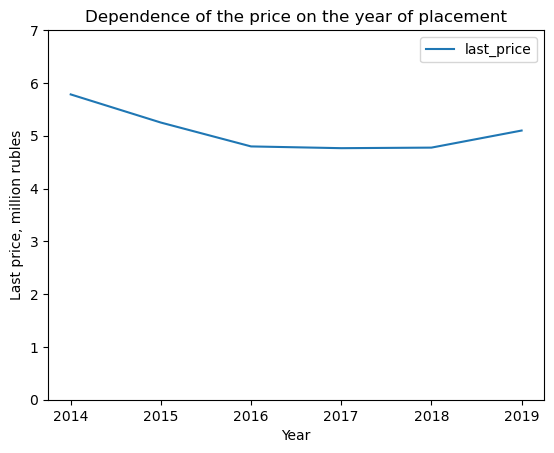

In [63]:
price_floor = data.pivot_table(index='year_exposition', values='last_price')
price_floor.plot(ylim=(0, 7), xlabel='Year',
                 ylabel='Last price, million rubles',
                 title='Dependence of the price on the year of placement');

In [64]:
data.pivot_table(index='year_exposition', values=['price_for_sqr_m',
                                                  'last_price',
                                                  'total_area'])

,last_price,price_for_sqr_m,total_area
year_exposition,,,
2014,5.782435,95784.034884,65.833365
2015,5.249180,90897.104839,59.703296
2016,4.797301,89493.747561,55.064963
2017,4.764220,90247.296426,54.375112
2018,4.774671,92317.407809,53.402734
2019,5.098105,98987.757611,53.888890


Although judging by the graph, it seems that prices fell until 2018, and in 2019 they began to grow a little, according to the summary table, we see that the whole point is that until 2016 the price per square meter fell, and from 2017 it began to grow, and in 2019 has grown very sharply, and despite the fact that the average area of sold apartments is falling from year to year, the total price is growing from 2017 to 2019

#### Let's calculate the average price of one square meter in 10 settlements with the largest number of ads

In [65]:
data['locality_name_changed'].value_counts().head(10)

locality_name_changed
санкт-петербург    15651
мурин                586
кудров               470
шушар                439
всеволожск           398
пушкин               369
колпин               338
парголов             327
гатчин               307
выборг               237
Name: count, dtype: int64

In [66]:
data['locality_name'].value_counts().head(10)

locality_name
Санкт-Петербург      15651
посёлок Мурино         520
посёлок Шушары         439
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: count, dtype: int64

The order of the first 10 locations with the most ads in the changed column is not the same as the original column, so we will use the `locality_name_changed` column

In [67]:
data['locality_name_changed'].value_counts().head(10)

locality_name_changed
санкт-петербург    15651
мурин                586
кудров               470
шушар                439
всеволожск           398
пушкин               369
колпин               338
парголов             327
гатчин               307
выборг               237
Name: count, dtype: int64

In [68]:
price_for_sqr_m = (
    data.pivot_table(index='locality_name_changed',
                     values='price_for_sqr_m', aggfunc=['count', 'mean']
                    ).rename(columns={'count':'Total ads',
                     'mean':'Average price per sqm'}).droplevel(1,axis=1)
   ).sort_values(by='Total ads', ascending=False).head(10) #sort by number of ads
price_for_sqr_m
 #make a pivot table with prices per square meter, count how many ads for each locality and
    #find the average price per square meter
    #rename columns


,Total ads,Average price per sqm
locality_name_changed,,
санкт-петербург,13550,105696.441328
мурин,586,86040.655290
кудров,468,95086.508547
шушар,436,78577.607798
всеволожск,394,67221.964467
пушкин,336,100461.616071
колпин,335,75221.441791
парголов,326,90331.837423
гатчин,303,68663.584158


In [69]:
price_for_sqr_m.sort_values(by='Average price per sqm', ascending=False) #сортируем по средней цене за кв.м.

,Total ads,Average price per sqm
locality_name_changed,,
санкт-петербург,13550,105696.441328
пушкин,336,100461.616071
кудров,468,95086.508547
парголов,326,90331.837423
мурин,586,86040.655290
шушар,436,78577.607798
колпин,335,75221.441791
гатчин,303,68663.584158
всеволожск,394,67221.964467


The highest prices for housing per square meter (among the 10 settlements with the largest number of ads) in St. Petersburg. Pushkin and Kudrovo. The lowest prices are in Gatchina, Vsevolozhsk and Vyborg

#### Now we select apartments in St. Petersburg using the locality_name column and calculate the average price for each kilometer

In [70]:
saint_p = data.query('locality_name == "Санкт-Петербург"')
saint_p

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality_name_changed,price_for_sqr_m,day_of_week_exposition,month_exposition,year_exposition,floor_type,city_centers_distance
0,20,NaN,108.00,2019-03-07,3,2.70,16.0,51.000000,8,False,...,2.0,755.0,NaN,санкт-петербург,NaN,3,3,2019,другой,16.0
2,10,5.196,56.00,2015-08-20,2,NaN,5.0,34.300000,4,False,...,2.0,574.0,558.0,санкт-петербург,92785.0,3,8,2015,другой,14.0
3,0,NaN,NaN,2015-07-24,3,NaN,14.0,NaN,9,False,...,3.0,234.0,424.0,санкт-петербург,NaN,4,7,2015,другой,7.0
4,2,10.000,100.00,2018-06-19,2,3.03,14.0,32.000000,13,False,...,1.0,48.0,121.0,санкт-петербург,100000.0,1,6,2018,другой,8.0
7,5,7.915,71.60,2019-04-18,2,NaN,24.0,40.450274,22,False,...,0.0,NaN,NaN,санкт-петербург,110544.0,3,4,2019,другой,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23603,13,3.550,35.30,2018-02-28,1,2.86,15.0,16.300000,4,False,...,2.0,652.0,29.0,санкт-петербург,100566.0,2,2,2018,другой,16.0
23604,3,5.500,52.00,2018-07-19,2,NaN,5.0,31.000000,2,False,...,0.0,NaN,15.0,санкт-петербург,105769.0,3,7,2018,другой,6.0
23605,11,9.470,72.90,2016-10-13,2,2.75,25.0,40.300000,7,False,...,1.0,806.0,519.0,санкт-петербург,129903.0,3,10,2016,другой,4.0
23608,9,9.700,NaN,2017-03-21,3,NaN,5.0,73.300000,3,False,...,3.0,381.0,NaN,санкт-петербург,NaN,1,3,2017,другой,4.0


In [71]:
saint_p.pivot_table(index='city_centers_distance', values=['last_price',
                                                           'price_for_sqr_m'],aggfunc='mean')

,last_price,price_for_sqr_m
city_centers_distance,,
0.0,8.398000,119157.500000
1.0,8.145277,122075.915789
2.0,7.970519,116426.911243
3.0,7.350003,110201.936441
4.0,7.606618,116456.390300
5.0,7.661225,121135.024433
6.0,7.108234,122721.997519
7.0,6.635321,116559.536842
8.0,6.602576,115926.241379


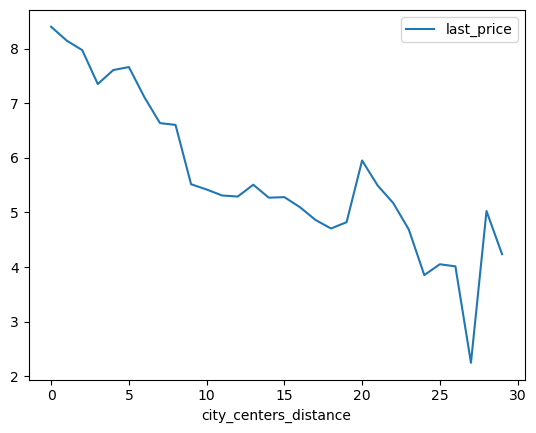

In [72]:
saint_p.pivot_table(index='city_centers_distance', values='last_price',
                    aggfunc='mean').plot();

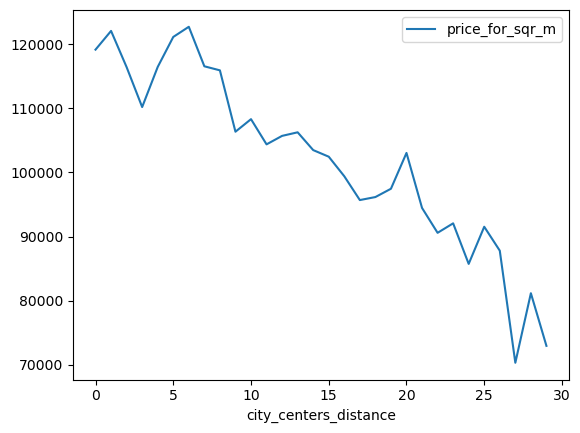

In [73]:
saint_p.pivot_table(index='city_centers_distance', values='price_for_sqr_m',
                    aggfunc='mean').plot();

The most expensive apartments in the city center, the farther from the center - the cheaper, both the total price and the price per square meter

We see a peak in the region of 27 kilometers. Googling, I found out that the distance from St. Petersburg to Vsevolozhsk by car is 27 km. Thus, it is possible that the name of the settlement should be changed for apartments with a distance from the center of St. Petersburg from 27 to 30 km from St. Petersburg to Vsevolozhsk

In [74]:
data.query('city_centers_distance > 27 & locality_name == "Санкт-Петербург"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,locality_name_changed,price_for_sqr_m,day_of_week_exposition,month_exposition,year_exposition,floor_type,city_centers_distance
810,0,7.600,111.0,2017-07-26,3,3.00,16.0,63.0,12,False,...,2.0,72.0,66.0,санкт-петербург,68468.0,2,7,2017,другой,28.0
1107,0,4.072,38.0,2015-10-14,1,NaN,5.0,16.0,4,False,...,0.0,NaN,285.0,санкт-петербург,107157.0,2,10,2015,другой,28.0
9541,0,3.413,43.0,2015-11-10,1,NaN,5.0,18.0,1,False,...,0.0,NaN,258.0,санкт-петербург,79372.0,1,11,2015,первый,28.0
10755,10,4.850,62.0,2017-05-16,3,NaN,5.0,35.7,1,False,...,0.0,NaN,63.0,санкт-петербург,78225.0,1,5,2017,первый,29.0
11602,16,4.700,51.0,2016-06-07,2,2.60,5.0,30.0,1,False,...,0.0,NaN,539.0,санкт-петербург,92156.0,1,6,2016,первый,29.0
12109,8,2.450,43.0,2018-08-14,1,2.75,5.0,16.0,1,True,...,0.0,NaN,8.0,санкт-петербург,56976.0,1,8,2018,первый,29.0
12977,16,4.200,56.8,2018-07-04,2,NaN,3.0,27.9,1,False,...,0.0,NaN,187.0,санкт-петербург,73943.0,2,7,2018,первый,29.0
16720,20,4.850,85.8,2019-04-22,3,NaN,3.0,49.4,2,False,...,0.0,NaN,NaN,санкт-петербург,56526.0,0,4,2019,другой,29.0
17728,0,4.990,71.0,2015-10-14,3,NaN,5.0,42.0,1,False,...,0.0,NaN,285.0,санкт-петербург,70281.0,2,10,2015,первый,28.0
18869,0,3.666,39.0,2015-11-09,1,NaN,5.0,16.0,2,False,...,0.0,NaN,259.0,санкт-петербург,94000.0,0,11,2015,другой,28.0


### General conclusion

#### Deadline for the sale of the apartment

Most often, an apartment is sold in 95 days. If less than 45 days, then it is fast, if longer than 230 days, it is a long time.
There are a large number of apartments sold in just a few days after the publication.
There are also options that have been on sale for several tens of months.

#### Factors affecting the cost

The cost is more influenced by the area of the apartment than the number of rooms. Those. there may be expensive apartments with a small number of rooms, but where the rooms are spacious.
The first floor is much cheaper than the other options. Also, the cost of an apartment on the top floor is lower than on the rest, except for the first one.

#### The cost per square meter in the top 10 settlements

The most expensive square meter in St. Petersburg - 114848
The cheapest square meter in Vyborg - 58141

Work was carried out to preprocess the data, eliminate implicit duplicates, and calculate additional metrics. We found out which settlements have the largest number of apartment ads, and what price per square meter these apartments have. We learned that the most expensive housing is in St. Petersburg, while the closer to the city center, the more expensive.